In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV
from sklearn.metrics import r2_score

In [7]:
import matplotlib
np.__version__

'1.18.5'

In [2]:
df = pd.read_csv('../data/Data_for_UCI_named.csv')

features = df.columns.to_list()
'Attributes in dataset {}: '.format(features)

"Attributes in dataset ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab', 'stabf']: "

In [3]:
df_char = pd.concat([df.dtypes,df.isna().sum()],axis=1)
df_char.rename(columns={0:'Data type',1:'Missing values'},inplace=True)
df_char

,Data type,Missing values
tau1,float64,0
tau2,float64,0
tau3,float64,0
tau4,float64,0
p1,float64,0
p2,float64,0
p3,float64,0
p4,float64,0
g1,float64,0
g2,float64,0


In [4]:
print('Number of values feature "stabf": {}'.format(df.stabf.nunique()))
df.stabf.value_counts()

Number of values feature "stabf": 2


unstable    6380
stable      3620
Name: stabf, dtype: int64

We can appreciate an unbalaced dataset.

In [5]:
df_stats = df.describe().T
df_stats.rename(columns={'25%':'Q1','50%':'median','75%':'Q3'},inplace=True)
df_stats

,count,mean,std,min,Q1,median,Q3,max
tau1,10000.0,5.250000,2.742548,0.500793,2.874892,5.250004,7.624690,9.999469
tau2,10000.0,5.250001,2.742549,0.500141,2.875140,5.249981,7.624893,9.999837
tau3,10000.0,5.250004,2.742549,0.500788,2.875522,5.249979,7.624948,9.999450
tau4,10000.0,5.249997,2.742556,0.500473,2.874950,5.249734,7.624838,9.999443
p1,10000.0,3.750000,0.752160,1.582590,3.218300,3.751025,4.282420,5.864418
p2,10000.0,-1.250000,0.433035,-1.999891,-1.624901,-1.249966,-0.874977,-0.500108
p3,10000.0,-1.250000,0.433035,-1.999945,-1.625025,-1.249974,-0.875043,-0.500072
p4,10000.0,-1.250000,0.433035,-1.999926,-1.624960,-1.250007,-0.875065,-0.500025
g1,10000.0,0.525000,0.274256,0.050009,0.287521,0.525009,0.762435,0.999937
g2,10000.0,0.525000,0.274255,0.050053,0.287552,0.525003,0.762490,0.999944


The reaction time (tau) for all 4 actors have almost the same statistical properties. However we know this does not imply that the distributions are the same (Anscombe's quartet). We perform a proportionate stratified sampling to better visualize this (first 4 diagonal plots) and also the relation between all variables.
NOTE: kde (kernel density estimation) plots joint pdf (probability distribution function) at diffetent levels (level curves)

In [25]:
grp = df.groupby(by='stabf')
sample = grp.apply(lambda x:x.sample(frac=0.01))
sns.pairplot(sample, kind = 'kde', diag_kind = 'hist') # Apply function group-wise and combine the results together.

tau1                                               535.478
tau2                                               522.682
tau3                                               470.592
tau4                                                529.59
p1                                                 377.073
p2                                                -131.716
p3                                                  -126.4
p4                                                -118.958
g1                                                 49.1713
g2                                                 57.1309
g3                                                 53.1849
g4                                                 53.3272
stab                                               1.57728
stabf    stablestablestablestablestablestablestablestab...
dtype: object

<AxesSubplot:>

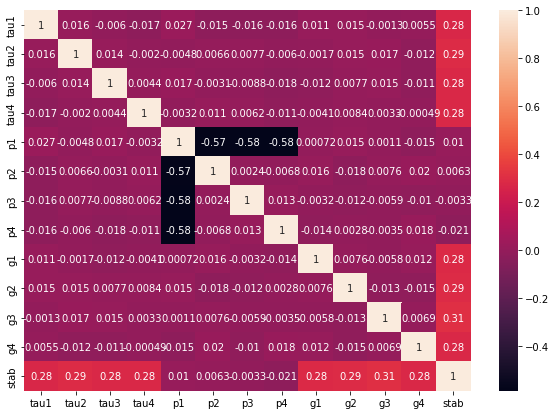

In [26]:
num_df = df.drop('stabf',axis=1)
_, ax = plt.subplots(figsize=(10,7))
corr_matrix = num_df.corr()
sns.heatmap(corr_matrix, annot = True, ax = ax)

Input variable p1 is not predictive because p1 = abs(p2 + p3 + p4). The target variable stab shows no correlation with all power related variables. We could exclude these in order to gain on interpretability. 

In [27]:
num_df.drop(['p1','p2','p3','p4'],axis=1,inplace=True)

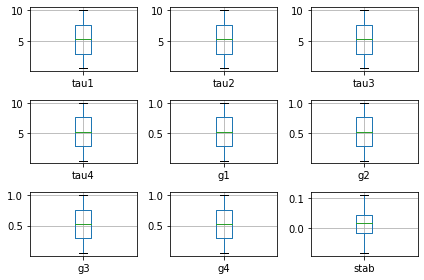

In [41]:
fig, axes = plt.subplots(3,3)
axes = axes.flatten()
for i, feature in enumerate(num_df.columns):
    num_df.boxplot(feature,ax=axes[i])
plt.tight_layout() 
plt.show()

Bloxplots reveal no outliers. Let's split the data for training, we stratify according to the variable stabf.

In [51]:
train, test = train_test_split(num_df,test_size=0.3,random_state = 42, stratify = df.stabf)
train_input, train_output = train.drop('stab',axis = 1), train.stab 
test_input, test_output = test.drop('stab',axis = 1), test.stab 
# scaling does not affect vanilla regression
std_scaler = StandardScaler()
train_scaled = std_scaler.fit_transform(train)
test_scaled = std_scaler.transform(test)

In [7]:
# steps parameter must be a list
pipe = Pipeline(
    steps = [
        ('pol',PolynomialFeatures(include_bias=False)),
        ('lr',LinearRegression())
    ]
)
 
grid = {
    'pol__degree':range(1,6)
}
search = GridSearchCV(pipe,
                      grid,
                      refit=True, # (default) fit grid search object with best parameters found
                      verbose=3
                     )
search.fit(train_input,train_output)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] pol__degree=1 ...................................................
[CV] ....................... pol__degree=1, score=0.635, total=   0.0s
[CV] pol__degree=1 ...................................................
[CV] ....................... pol__degree=1, score=0.658, total=   0.0s
[CV] pol__degree=1 ...................................................
[CV] ....................... pol__degree=1, score=0.647, total=   0.0s
[CV] pol__degree=1 ...................................................
[CV] ....................... pol__degree=1, score=0.617, total=   0.0s
[CV] pol__degree=1 ...................................................
[CV] ....................... pol__degree=1, score=0.673, total=   0.0s
[CV] pol__degree=2 ...................................................
[CV] ....................... pol__degree=2, score=0.890, total=   0.0s
[CV] pol__degree=2 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ....................... pol__degree=2, score=0.890, total=   0.0s
[CV] pol__degree=2 ...................................................
[CV] ....................... pol__degree=2, score=0.889, total=   0.1s
[CV] pol__degree=2 ...................................................
[CV] ....................... pol__degree=2, score=0.880, total=   0.0s
[CV] pol__degree=2 ...................................................
[CV] ....................... pol__degree=2, score=0.885, total=   0.0s
[CV] pol__degree=3 ...................................................
[CV] ....................... pol__degree=3, score=0.949, total=   0.1s
[CV] pol__degree=3 ...................................................
[CV] ....................... pol__degree=3, score=0.947, total=   0.1s
[CV] pol__degree=3 ...................................................
[CV] ....................... pol__degree=3, score=0.949, total=   0.1s
[CV] pol__degree=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.9min finished


GridSearchCV(estimator=Pipeline(steps=[('pol',
                                        PolynomialFeatures(include_bias=False)),
                                       ('lr', LinearRegression())]),
             param_grid={'pol__degree': range(1, 7)}, verbose=3)

In [29]:
results_dict = search.cv_results_
results_df = pd.DataFrame.from_dict(results_dict)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pol__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016743,0.007462,0.008925,0.003244,1,{'pol__degree': 1},0.634728,0.658105,0.647197,0.617233,0.672704,0.645993,0.019056,6
1,0.025849,0.006409,0.005289,0.000554,2,{'pol__degree': 2},0.889814,0.890456,0.889250,0.879931,0.885268,0.886944,0.003947,5
2,0.098784,0.010363,0.006423,0.000982,3,{'pol__degree': 3},0.948530,0.947360,0.948914,0.938647,0.946551,0.946000,0.003771,3
3,0.314682,0.017781,0.010691,0.001356,4,{'pol__degree': 4},0.961501,0.961687,0.961794,0.953317,0.960032,0.959666,0.003238,1
4,2.039709,0.175922,0.019398,0.002593,5,{'pol__degree': 5},0.962260,0.963316,0.963094,0.953835,0.954975,0.959496,0.004187,2
5,17.197208,0.756790,0.039391,0.006140,6,{'pol__degree': 6},0.919150,0.926376,0.923151,0.909087,0.921659,0.919885,0.005883,4


In [52]:
score = search.best_score_
degree = search.best_params_['pol__degree']
'The best r2 score on the training set is {:.4f} and obtained for polynomial degree {}'.format(score,degree)   

'The best r2 score is equal to 0.9597 and obtained for polynomial degree equal to 4'

In [54]:
prediction = search.predict(test_input)
test_score = r2_score(test_output,prediction)
print('The best r2 score on the test set is {:.4f}. The model is generalizing correctly'.format(test_score))  

'The best r2 score on the test set is 0.9625'

Let's visualize the predictions versus ground truth labels. These should follow the identity line.

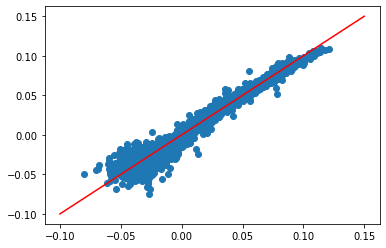

In [51]:
plt.scatter(prediction,test_output)
plt.plot([-0.1, 0.15], [-0.1, 0.15], color='red')

Now, let's create aggregate features (min, max, and mean) of reaction time (tau) and price elasticity (g)

In [30]:
tau_df = num_df[['tau1','tau2','tau3','tau4']]
g_df = num_df[['g1','g2','g3','g4']]
agg = {
    'tau_min':tau_df.min(axis=1),
    'tau_max':tau_df.max(axis=1),
    'tau_mean':tau_df.mean(axis=1),
    'g_min':g_df.min(axis=1),
    'g_max':g_df.max(axis=1),
    'g_mean':g_df.mean(axis=1),
    #'stab':df.stab,
    #'stabf':df.stabf
}
agg_df = pd.DataFrame(agg)

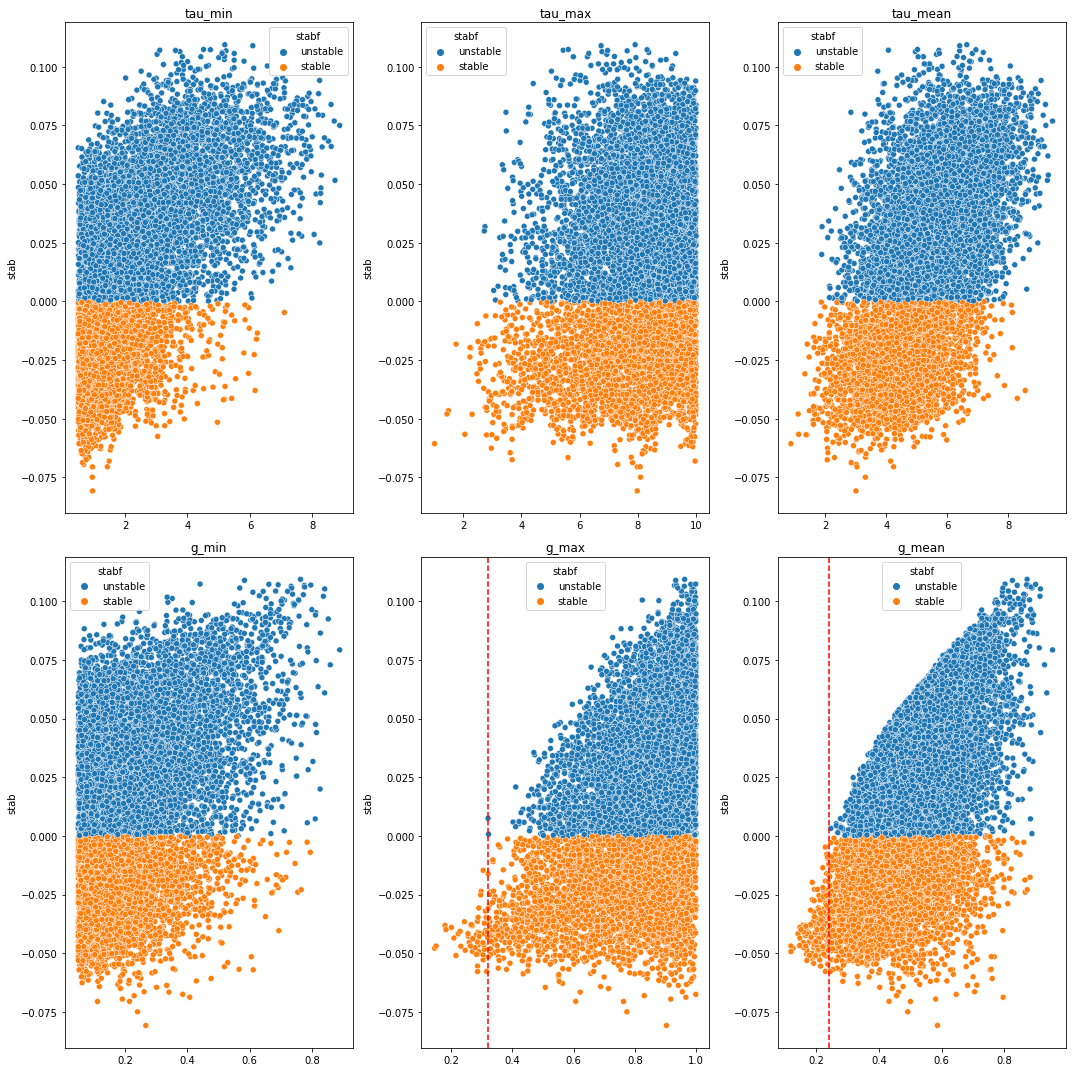

In [31]:
fig, axes = plt.subplots(2,3,figsize=(15,15))
axes = axes.flatten()
for i, feature in enumerate(agg_df.columns):
    sns.scatterplot(
        x=agg[feature],
        y=df['stab'],
        hue=df['stabf'],
        ax=axes[i]
    )
    axes[i].set_title(feature)
    
# Draw red lines marking stable regions
axes[4].axvline(x=0.32,color='red',linestyle='--')
axes[5].axvline(x=0.24,color='red',linestyle='--')

plt.tight_layout() 
plt.show()

We appreciate semi intervals 
- g_mean < 0.24, 
- g_max < 0.32,

where the network is stable. In 'Towards Concise Models of Grid Stability' the authors use decision trees to obtain more complex stability regions.

In [80]:
pipe_elstc = Pipeline(
    steps = [
        ('pol',PolynomialFeatures(include_bias=False)),
        ('std',StandardScaler()),
        ('elstc',ElasticNetCV(n_alphas=50,max_iter=1e4))
    ]
)
 
grid_elstc = {
    'pol__degree':range(1,5),
    'elstc__l1_ratio':np.linspace(0.1,1,num=10) # alphas cannot be automatically generated for l1_ratio = 0
    
}
search_elstc = GridSearchCV(pipe_elstc,
                      grid_elstc,
                      refit=True, # (default) fit grid search object with best parameters found
                      verbose=3
                     )
search_elstc.fit(train_scaled_input,train_output)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] elstc__l1_ratio=0.1, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=1, score=0.635, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=1, score=0.658, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=1 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .. elstc__l1_ratio=0.1, pol__degree=1, score=0.647, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=1, score=0.617, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=1, score=0.673, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=2 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=2, score=0.890, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=2 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=2, score=0.891, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=2 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=2, score=0.889, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=2 ..............................
[CV] .. elstc__l1_ratio=0.1, pol__degree=2, score=0.880, total=   0.1s
[CV] elstc__l1_ratio=0.1, pol__degree=2 ..............................
[CV] .

[CV]  elstc__l1_ratio=0.30000000000000004, pol__degree=4, score=0.954, total=   2.0s
[CV] elstc__l1_ratio=0.30000000000000004, pol__degree=4 ..............
[CV]  elstc__l1_ratio=0.30000000000000004, pol__degree=4, score=0.960, total=   2.0s
[CV] elstc__l1_ratio=0.4, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.4, pol__degree=1, score=0.635, total=   0.1s
[CV] elstc__l1_ratio=0.4, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.4, pol__degree=1, score=0.658, total=   0.1s
[CV] elstc__l1_ratio=0.4, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.4, pol__degree=1, score=0.647, total=   0.1s
[CV] elstc__l1_ratio=0.4, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.4, pol__degree=1, score=0.617, total=   0.1s
[CV] elstc__l1_ratio=0.4, pol__degree=1 ..............................
[CV] .. elstc__l1_ratio=0.4, pol__degree=1, score=0.673, total=   0.1s
[CV] elstc__l1_ratio=0.4, pol__degree=2 .........

[CV] .. elstc__l1_ratio=0.6, pol__degree=4, score=0.962, total=   2.1s
[CV] elstc__l1_ratio=0.6, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.6, pol__degree=4, score=0.962, total=   2.2s
[CV] elstc__l1_ratio=0.6, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.6, pol__degree=4, score=0.954, total=   2.2s
[CV] elstc__l1_ratio=0.6, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.6, pol__degree=4, score=0.960, total=   2.1s
[CV] elstc__l1_ratio=0.7000000000000001, pol__degree=1 ...............
[CV]  elstc__l1_ratio=0.7000000000000001, pol__degree=1, score=0.635, total=   0.1s
[CV] elstc__l1_ratio=0.7000000000000001, pol__degree=1 ...............
[CV]  elstc__l1_ratio=0.7000000000000001, pol__degree=1, score=0.658, total=   0.1s
[CV] elstc__l1_ratio=0.7000000000000001, pol__degree=1 ...............
[CV]  elstc__l1_ratio=0.7000000000000001, pol__degree=1, score=0.647, total=   0.1s
[CV] elstc__l1_ratio=0.700000000000000

[CV] .. elstc__l1_ratio=0.9, pol__degree=3, score=0.949, total=   0.4s
[CV] elstc__l1_ratio=0.9, pol__degree=3 ..............................
[CV] .. elstc__l1_ratio=0.9, pol__degree=3, score=0.939, total=   0.5s
[CV] elstc__l1_ratio=0.9, pol__degree=3 ..............................
[CV] .. elstc__l1_ratio=0.9, pol__degree=3, score=0.946, total=   0.4s
[CV] elstc__l1_ratio=0.9, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.9, pol__degree=4, score=0.962, total=   2.3s
[CV] elstc__l1_ratio=0.9, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.9, pol__degree=4, score=0.962, total=   2.5s
[CV] elstc__l1_ratio=0.9, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.9, pol__degree=4, score=0.962, total=   2.3s
[CV] elstc__l1_ratio=0.9, pol__degree=4 ..............................
[CV] .. elstc__l1_ratio=0.9, pol__degree=4, score=0.954, total=   2.1s
[CV] elstc__l1_ratio=0.9, pol__degree=4 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


GridSearchCV(estimator=Pipeline(steps=[('pol',
                                        PolynomialFeatures(include_bias=False)),
                                       ('std', StandardScaler()),
                                       ('elstc',
                                        ElasticNetCV(max_iter=10000.0,
                                                     n_alphas=50))]),
             param_grid={'elstc__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'pol__degree': range(1, 5)},
             verbose=3)

In [81]:
print('Tuned Hyperparameters: ',search_elstc.best_params_)
print('Accuracy: ', search_elstc.best_score_)

Tuned Hyperparameters:  {'elstc__l1_ratio': 1.0, 'pol__degree': 4}
Accuracy:  0.9600408310548183


The grid search on ElasticNetCV chooses the l1 ratio to be equal to 1, so it becomes a Lasso regressor.

In [84]:
l1_ratio = search_elstc.best_params_['elstc__l1_ratio']
degree = search_elstc.best_params_['pol__degree']

lasso = LassoCV(
    n_alphas=50,
    max_iter=1e4,
)

pol = PolynomialFeatures(
    degree=degree,
    include_bias=False
)

pipe_lasso = Pipeline(
    steps = [
        ('pol',pol),
        ('std',StandardScaler()),
        ('lasso',lasso)
    ]
)
        
pipe_lasso.fit(train_input,train_output)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013812862821791505, tolerance: 0.0009460048504141328
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('pol', PolynomialFeatures(degree=4, include_bias=False)),
                ('std', StandardScaler()),
                ('lasso', LassoCV(max_iter=10000.0, n_alphas=50))])

Let's examine the coefficients

In [85]:
coefs = pipe_lasso['lasso'].coef_
feats = pol.get_feature_names()

trans = dict(zip(feats[:8],train_input.columns))
for i in range(len(feats)):
    for key in trans:
        if key in feats[i]:
            feats[i] = feats[i].replace(key,trans[key])

weights = list(zip(feats,coefs))
weights.sort(reverse=True,key=lambda x:np.abs(x[1]))
weights

[('tau1 g1', 0.020782277152751025),
 ('tau3 g3', 0.020183241881194598),
 ('tau4 g4', 0.018533695544328318),
 ('tau2 g2', 0.016166060931615756),
 ('tau2 g2^2', 0.016121912991055656),
 ('tau2^2 g2^2', -0.013994003870571127),
 ('tau4 g4^2', 0.011172398145514848),
 ('tau3 g3^2', 0.010810000416619246),
 ('tau2 tau4 g2', 0.010091985215583498),
 ('tau3 tau4 g4', 0.009566670999403691),
 ('tau3^2 g3^2', -0.00952485030914829),
 ('tau4^2 g4^2', -0.009239884689107592),
 ('tau2 tau3 g3', 0.009063526661337987),
 ('tau1^2 g1 g4', -0.008175553792570246),
 ('tau2^2 g2 g4', -0.008094616557802598),
 ('tau1 tau2 g2', 0.008006463223500897),
 ('tau2 tau4 g4', 0.007432986494554977),
 ('tau1 g1^2', 0.007412929090142833),
 ('tau1^2 g1 g3', -0.007211794944566854),
 ('tau1^2 g1^2', -0.007161370285697423),
 ('tau3^2 g1 g3', -0.006730391375772835),
 ('tau3 tau4 g3', 0.00669586832737899),
 ('tau4^2 g1 g4', -0.006523620830277944),
 ('tau2 tau3 g2', 0.006489589574530478),
 ('tau2^2 g1 g2', -0.006377655105744952),
 ('

Lasso is setting most of the coefficients to zero, which is to be expected. Let's plot the non-zero coefficients to appreciate how much they contribute to prediction. 

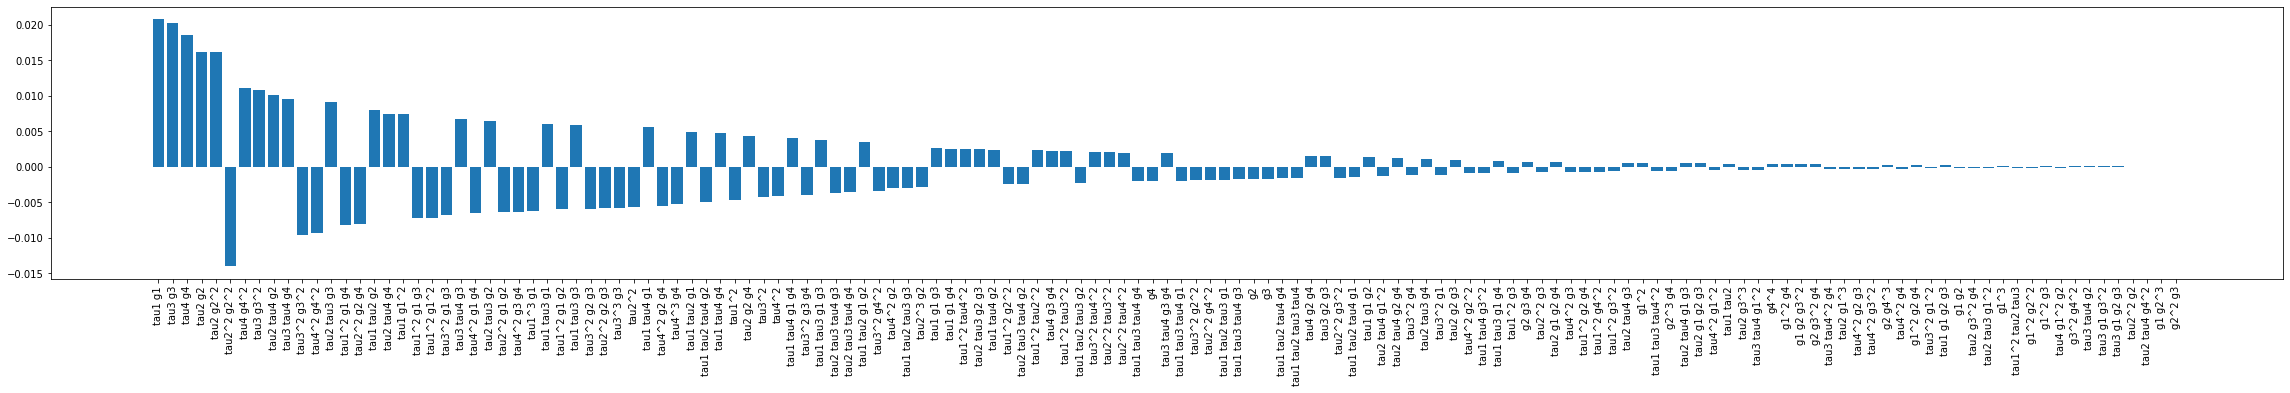

In [93]:
nzero_weights = [weight for weight in weights if weight[1]!=0]
plt.figure(figsize=(40, 5))
plt.bar(*zip(*nzero_weights))
plt.xticks(rotation='vertical')
plt.show()

Among the first 10 most influential coefficients we obtain monomials of degrees 2, 3, and 4 in the original variables. This explains why the grid search chose the best polynomial degree to be equal to 4.